# IMBD Data Analytics with Python
## Guia de Análise Exploratória de Dados com Python e Linguagem SQL

In [2]:
# Fazendo os imports dos pacotes necessários para análise
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import date
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [3]:
%%time 
# magic function has to be the first thing in the IPython (Jupyter) cell

# Baixando e carregando Dados do IMDB com a lib imdb-sqlite
!imdb-sqlite

2021-07-15 18:07:25,339 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 5.15 ms, sys: 12.7 ms, total: 17.8 ms
Wall time: 242 ms


In [4]:
# Conecta no banco de dados
conn = sqlite3.connect("imdb.db")

In [5]:
# Extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [6]:
# Converte o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()
tabelas

['people', 'titles', 'akas', 'crew', 'episodes', 'ratings']

In [7]:
# Percorre a lista de tabelas no banco de dados e extrair o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




## 1. Quais São as Categorias de Filmes Mais Comuns no IMDB?
Quais são os principais tipos (categorias) dos títulos (filmes)?

In [8]:
df1 = pd.read_sql_query('SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type ORDER BY COUNT DESC', conn)
df1

,type,COUNT
0,tvEpisode,5911778
1,short,820435
2,movie,582234
3,video,313892
4,tvSeries,210679
5,tvMovie,132085
6,tvMiniSeries,38285
7,tvSpecial,33315
8,videoGame,28560
9,tvShort,10148


In [9]:
# Calcula o percentual para cada tipo
df1['percentual'] = (df1['COUNT'] / df1['COUNT'].sum()) * 100
df1

,type,COUNT,percentual
0,tvEpisode,5911778,73.152777
1,short,820435,10.152123
2,movie,582234,7.204606
3,video,313892,3.884123
4,tvSeries,210679,2.606957
5,tvMovie,132085,1.634430
6,tvMiniSeries,38285,0.473741
7,tvSpecial,33315,0.412242
8,videoGame,28560,0.353404
9,tvShort,10148,0.125572


In [10]:
# Vamos criar um gráfico com apenas 4 categorias:
# As 3 categorias com mais títulos e 1 categoria com todo o restante

# Cria um dicionário vazio
others = {}

# Filtra o percentual em 5% e soma o total
others['COUNT'] = df1[df1['percentual'] < 5]['COUNT'].sum()

# Grava o percentual
others['percentual'] = df1[df1['percentual'] < 5]['percentual'].sum()

# Ajusta o nome
others['type'] = 'others'
others

{'COUNT': 766966, 'percentual': 9.490493803496989, 'type': 'others'}

In [11]:
# Filtra o dataframe de resultado
df1 = df1[df1['percentual'] > 5]

In [12]:
# Append com o dataframe de outras categorias
df1 = df1.append(others, ignore_index = True)

In [13]:
# Ordena e mostra o resultado
df1 = df1.sort_values(by = 'COUNT', ascending = False)
df1

,type,COUNT,percentual
0,tvEpisode,5911778,73.152777
1,short,820435,10.152123
3,others,766966,9.490494
2,movie,582234,7.204606


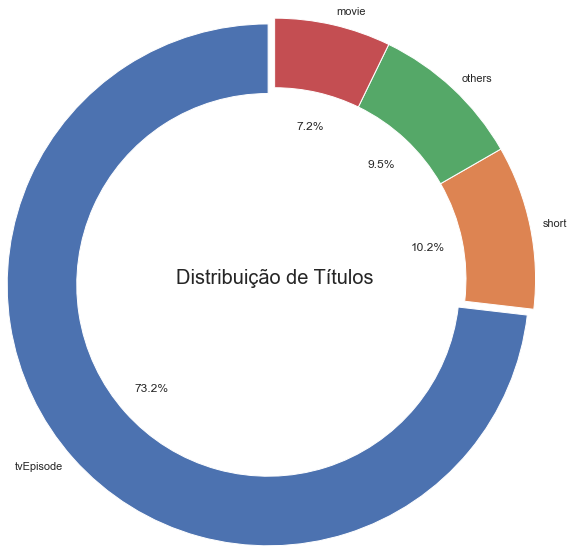

In [14]:
# Plotando os dados em um gráfico de pizza
labels = df1['type'].values.tolist()
sizes = df1['percentual'].values.tolist()
explode = (0.1, 0, 0, 0)  # only "explode" the 1º slice (i.e. 'tvEpisode')

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, 
labeldistance=1.05, radius=3, wedgeprops = dict(width = 0.8))
plt.title("Distribuição de Títulos", loc = 'center', fontdict = {'fontsize':20, 'fontweight':20}, y=0.45)
plt.show()

## 2. Qual o Número de Títulos Por Gênero?
Vamos calcular o número de filmes por gênero e entregar o resultado em valor percentual.

In [15]:
# Resultado
df2 = pd.read_sql_query("SELECT genres, COUNT(*) as COUNT FROM titles WHERE type = 'movie' GROUP BY genres ORDER BY genres", conn)
df2

,genres,COUNT
0,Action,13246
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1438,"Thriller,Western",36
1439,War,1249
1440,"War,Western",9
1441,Western,4050


In [16]:
# Converte as strings para minúsculo
df2['genres'] = df2['genres'].str.lower().values

In [17]:
# Remove valores NA (ausentes)
temp = df2['genres'].dropna()

Usamos o Countvectorizer para converter a coluna de gêneros em um vetor one-hot encoded para contar o número de filmes em cada gênero.

![title](imagens/one-hot.png)

In [18]:
# Vamos criar um vetor usando expressão regular para filtrar as strings

# https://docs.python.org/3.8/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

# Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

# Retorna gêneros únicos
generos_unicos =  vetor.get_feature_names()

# Cria o dataframe de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)
generos

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1441,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
# Drop da coluna n
generos = generos.drop(columns = 'n', axis = 0)

In [20]:
# Visualiza
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 0 to 1442
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1443 non-null   int64
 1   adult        1443 non-null   int64
 2   adventure    1443 non-null   int64
 3   animation    1443 non-null   int64
 4   biography    1443 non-null   int64
 5   comedy       1443 non-null   int64
 6   crime        1443 non-null   int64
 7   documentary  1443 non-null   int64
 8   drama        1443 non-null   int64
 9   family       1443 non-null   int64
 10  fantasy      1443 non-null   int64
 11  film-noir    1443 non-null   int64
 12  game-show    1443 non-null   int64
 13  history      1443 non-null   int64
 14  horror       1443 non-null   int64
 15  music        1443 non-null   int64
 16  musical      1443 non-null   int64
 17  mystery      1443 non-null   int64
 18  news         1443 non-null   int64
 19  reality-tv   1443 non-null   int64
 20  romance 

In [21]:
# Series de Total por genero
sr = pd.Series(generos.sum()).sort_values(ascending = False)
sr

drama          267
comedy         242
documentary    231
adventure      215
action         211
romance        194
crime          188
mystery        181
thriller       180
fantasy        177
horror         171
history        170
music          160
family         160
animation      160
biography      154
sci-fi         154
musical        150
western        128
war            128
sport          118
adult           88
news            52
reality-tv      42
film-noir       34
short           26
talk-show       14
game-show        6
dtype: int64

In [22]:
# Calcula o percentual
total_generos = generos.shape[0]
generos_percentual = 100 * sr / total_generos
generos_percentual

drama          18.503119
comedy         16.770617
documentary    16.008316
adventure      14.899515
action         14.622315
romance        13.444213
crime          13.028413
mystery        12.543313
thriller       12.474012
fantasy        12.266112
horror         11.850312
history        11.781012
music          11.088011
family         11.088011
animation      11.088011
biography      10.672211
sci-fi         10.672211
musical        10.395010
western         8.870409
war             8.870409
sport           8.177408
adult           6.098406
news            3.603604
reality-tv      2.910603
film-noir       2.356202
short           1.801802
talk-show       0.970201
game-show       0.415800
dtype: float64

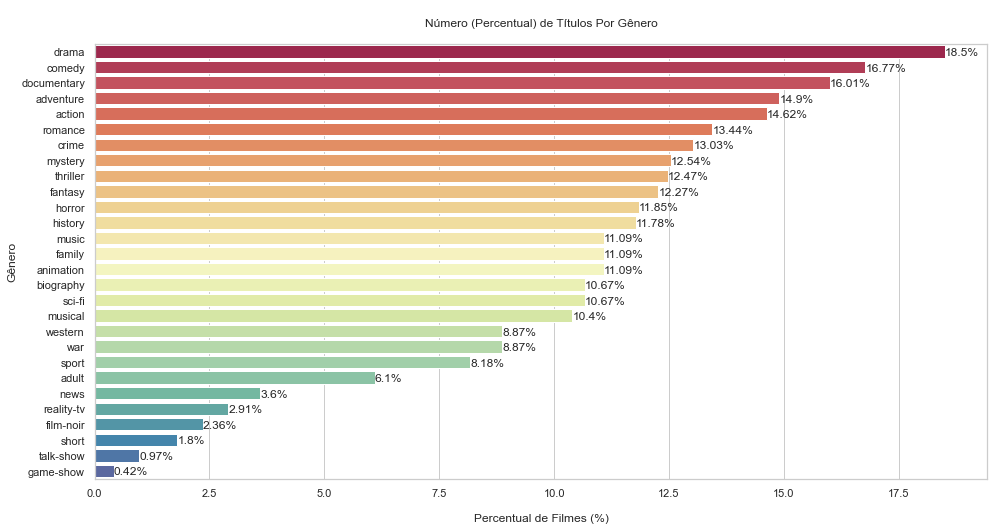

In [23]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "Spectral")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')

# Textos do gráfico
for i in range(len(generos_percentual.index)):

    plt.text(generos_percentual.values[i], 
             i + 0.25,
             str(round(generos_percentual.values[i], 2)) + "%")

plt.show()

## 3. Qual a Mediana de Avaliação dos Filmes Por Gênero?

Mediana de avaliação dos filmes.

In [24]:
cur_year = date.today().year

# Consulta SQL
query = "SELECT rating, genres FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= %d AND type = 'movie'" % cur_year

In [25]:
df3 = pd.read_sql_query(query, conn)
df3

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
265829,3.6,"Action,Adventure,Thriller"
265830,5.7,Thriller
265831,6.3,"Adventure,Drama,History"
265832,3.8,"Adventure,History,War"


In [26]:
# Vamos criar uma função para retornar os genêros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [27]:
# Aplica a função
generos_unicos = retorna_generos(df3)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [28]:
# Cria listas vazias
genero_counts = []
genero_ratings = []

for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = "SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '%s' AND type='movie'" % ('%'+item+'%')
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
    # Retorna a avaliação de filmes por gênero
    consulta = "SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '%s' AND type='movie'" % ('%'+ item+'%')
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

# Prepara o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings
df_genero_ratings

,genres,count,rating
0,action,28514,5.80
1,adult,4074,5.80
2,adventure,17530,6.00
3,animation,4620,6.40
4,biography,7968,7.00
5,comedy,66363,6.00
6,crime,22934,6.10
7,documentary,38842,7.30
8,drama,118041,6.30
9,family,10121,6.30


In [29]:
# Drop do índice 18 (news)
# Não queremos essa informação como gênero
df_genero_ratings = df_genero_ratings.drop(index = 18)

# Ordena o resultado
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

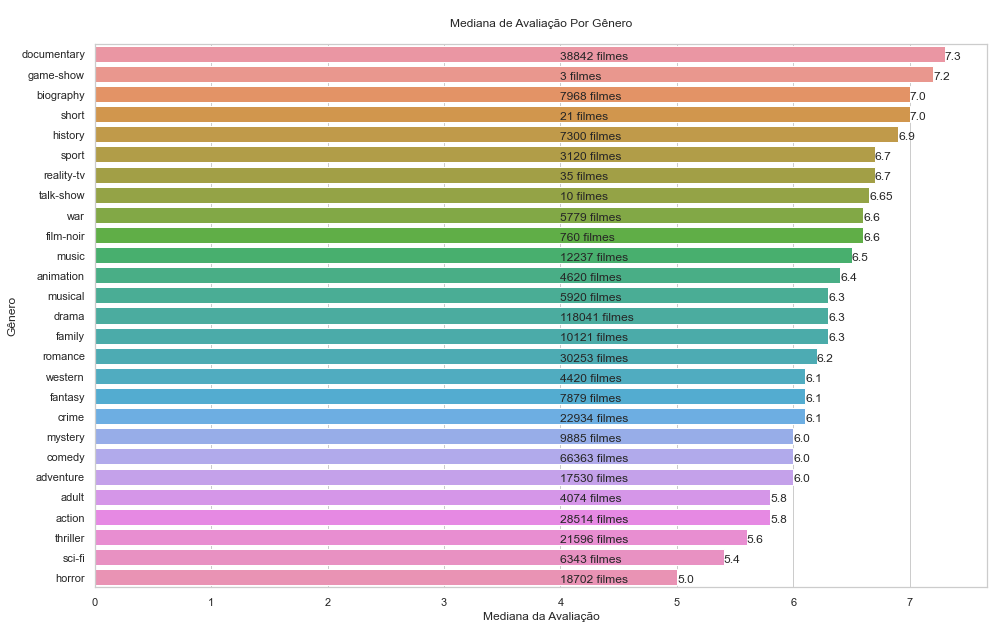

In [30]:
# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

## 4. Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

Mediana de avaliação dos filmes.

In [31]:
# Consulta SQL
query = "SELECT rating, premiered FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= %d AND type = 'movie' ORDER BY premiered" % cur_year

# Resultado
df4 = pd.read_sql_query(query, conn)
df4

,rating,premiered
0,6.4,1896
1,4.4,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900
...,...,...
265829,6.6,2021
265830,4.8,2021
265831,8.3,2021
265832,6.0,2021


In [32]:
# Calculano mediana agrupando os anos para timeline
df4_mean = df4.groupby(['premiered'], sort=True)['rating'].mean().reset_index(name='meanRating')
df4_mean = df4_mean[["premiered", "meanRating"]] # Reordenando as colunas
df4_mean

,premiered,meanRating
0,1896,6.400000
1,1897,4.400000
2,1899,3.800000
3,1900,6.150000
4,1901,4.500000
...,...,...
120,2017,6.238446
121,2018,6.143761
122,2019,6.166184
123,2020,6.217722


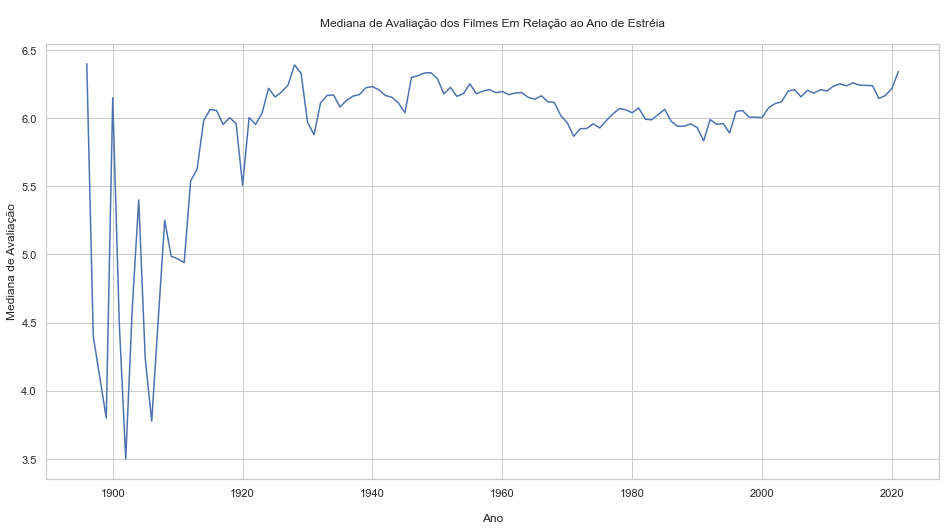

In [33]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(df4_mean.premiered, df4_mean.meanRating)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

## 5. Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

Número de filmes por gênero. Vamos listar os Top 5.

In [34]:
df5 = pd.read_sql_query("SELECT genres FROM titles", conn)

# Retorna gêneros únicos
generos_unicos = retorna_generos(df5)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [35]:
# Agora fazemos a contagem
genero_count = []
for item in generos_unicos:
    consulta = "SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '%s' AND type='movie' AND premiered <= %d" % (('%'+item+'%'), cur_year)
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

# Prepara o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['count'] = genero_count

# Filtrando e removendo genero 'n' do Dataframe
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']

# Ordenando decrescente pela contagem
df_genero_count = df_genero_count.sort_values(by='count', ascending=False)

# Obtendo os generos TOP 5 
top_generos = df_genero_count.head()['genre'].values

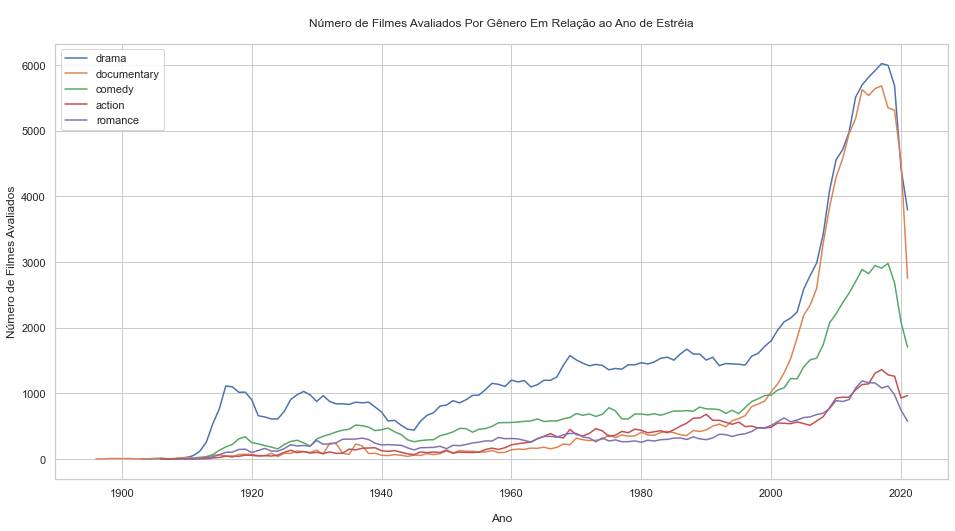

In [36]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = "SELECT COUNT(*) Number_of_Movies, premiered Year FROM  titles  WHERE genres LIKE '%s' AND type='movie' AND Year <= %d GROUP BY Year" % (('%'+item+'%'), cur_year)
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_Movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

## 6. Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.

Percentis e filme mais longo da história.

In [37]:
# Refazendo a consulta e retornando o filme com maior duração
query = '''
            SELECT runtime_minutes AS runtime, primary_title AS movie_title
            FROM titles WHERE type = 'movie' AND Runtime != 'NaN'
        '''

df6 = pd.read_sql_query(query, conn)
df6

,runtime,movie_title
0,100,Bohemios
1,70,The Story of the Kelly Gang
2,90,The Prodigal Son
3,120,The Fairylogue and Radio-Plays
4,58,Don Juan de Serrallonga
...,...,...
366532,123,Kuambil Lagi Hatiku
366533,57,Rodolpho Teóphilo - O Legado de um Pioneiro
366534,100,De la ilusión al desconcierto: cine colombiano...
366535,116,6 Gunn


In [38]:
# Gerando um Rank em Percentil para validar o filme de maior duração
# study base: https://www.geeksforgeeks.org/percentile-rank-of-a-column-in-a-pandas-dataframe/

df6['percentile_rank'] = df6.runtime.rank(pct = True)
df6.sort_values(by='percentile_rank', ascending=False, inplace=True)
df6

,runtime,movie_title,percentile_rank
349868,51420,Logistics,1.000000
287507,43200,Ambiancé,0.999997
190052,28643,Carnets Filmés (Liste Complète),0.999995
263855,14400,Modern Times Forever,0.999992
174733,10062,Qw,0.999989
...,...,...,...
136920,1,Bairaag,0.000010
219196,1,Talion,0.000010
190855,1,Communist Shrek,0.000010
203836,1,Corona Extra TV Commercial Featuring Jon Gruden,0.000010


In [39]:
print("O filme de maior duração se chama '%s' com duração de %d minutos!" % (df6.iloc[0]['movie_title'], df6.iloc[0]['runtime']))

O filme de maior duração se chama 'Logistics' com duração de 51420 minutos!


## 7. Qual a Relação Entre Duração e Gênero?

Relação entre duração do filme e gênero.

In [40]:
# Consulta SQL
query = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            ''' 

In [41]:
# Resultado
df7 = pd.read_sql_query(query, conn)

# Retorna gêneros únicos
generos_unicos = retorna_generos(df7)
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [42]:
# Calcula duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = "SELECT runtime_minutes AS runtime FROM titles WHERE genres LIKE '%s' AND type='movie' AND runtime!='NaN'" % ('%'+item+'%')
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['runtime']))

In [43]:
# Prepara o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

# Remove índice 18 (news)
df_genero_runtime = df_genero_runtime.drop(index = 18)

# Ordena os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

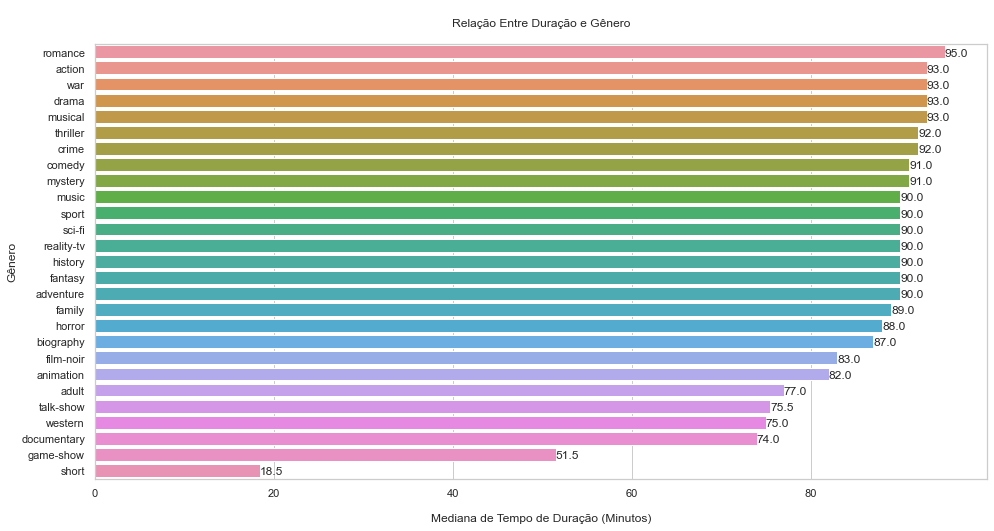

In [44]:
# Plot

# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

## 8. Qual o Número de Filmes Produzidos Por País?

Número de filmes produzidos por país.

In [51]:
# Consulta SQL
query = '''
            SELECT region, COUNT(*) Number_of_Movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
        ''' 

df8 = pd.read_sql_query(query, conn)
df8

,region,Number_of_Movies
0,AD,22
1,AE,320
2,AF,108
3,AG,12
4,AL,1230
...,...,...
227,YUCS,146
228,ZA,2943
229,ZM,11
230,ZRCD,2


In [52]:
# Número de linhas
df8.shape[0]

232

In [53]:
# Listas auxiliares
nomes_paises = []
contagem = []

# Loop para obter o país de acordo com a região
for i in range(df8.shape[0]):
    try:
        coun = df8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(df8['Number_of_Movies'].values[i])
    except: 
        continue

In [54]:
# Prepara o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

# Ordena o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)
df_filmes_paises

,country,Movie_Count
198,United States,256849
65,United Kingdom,114029
96,Japan,87840
63,France,81092
89,India,70918
...,...,...
130,Northern Mariana Islands,1
168,Solomon Islands,1
141,New Caledonia,1
100,Kiribati,1


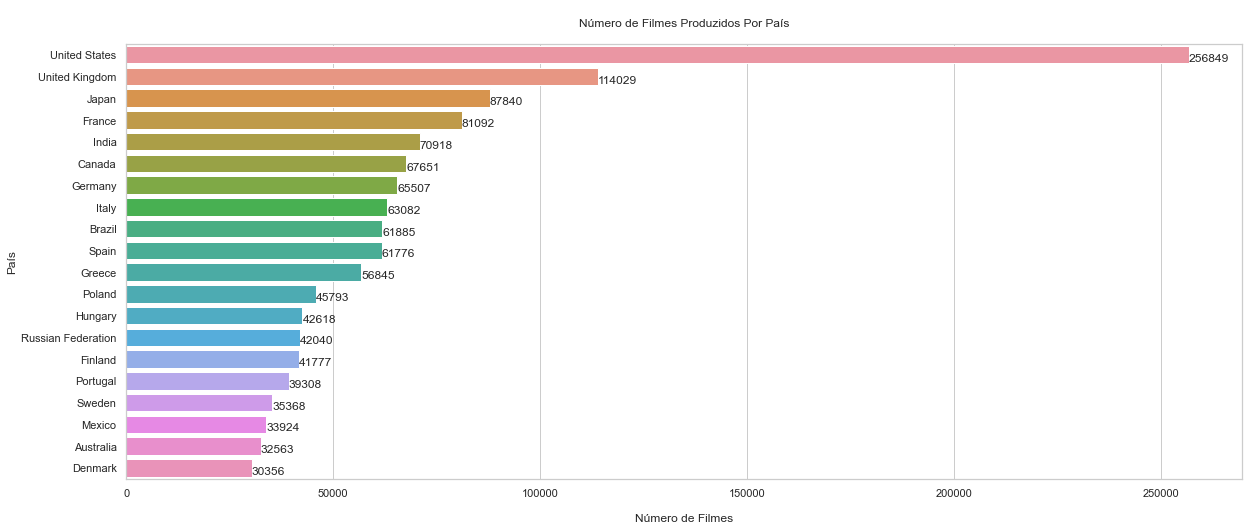

In [55]:
# Plot

# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

## 9. Quais São os Top 10 Melhores Filmes?

Top 10 filmes com melhor avaliação e mais de 25 mil votos.

In [56]:
# Consulta SQL
query = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
      '''

top10_melhores_filmes = pd.read_sql_query(query, conn)
top10_melhores_filmes

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.2
4,Soorarai Pottru,Drama,9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather: Part II,"Crime,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,Dara of Jasenovac,"Drama,War",9.0
9,David Attenborough: A Life on Our Planet,"Biography,Documentary",9.0


## 10. Quais São os Top 10 Piores Filmes?

Top 10 filmes com pior avaliação e mais de 25 mil votos.

In [57]:
# Consulta SQL
query = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            ''' 

top10_piores_filmes = pd.read_sql_query(query, conn)
top10_piores_filmes

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Smolensk,"Drama,Thriller",1.1
2,Sadak 2,"Action,Drama",1.1
3,Reis,"Biography,Drama",1.4
4,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5,Manos: the Hands of Fate,"Drama,Horror",1.8
6,Radhe,"Action,Crime,Thriller",1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Disaster Movie,"Comedy,Sci-Fi",1.9
